In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd,gluon,nd
from mxnet.gluon import data as gdata,loss as gloss,nn

In [12]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2),nd.power(features, 3))
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
+ true_w[2] * poly_features[:, 2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [4]:
#作图
def semilogy(x_vals,y_vals,x_label,y_label,x2_vals = None,y2_vals = None,legend = None,figsize=(3.5,2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals,y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals,y2_vals,linestyle = ':')
        d2l.plt.legend(legend)
        
        

In [7]:
num_epochs ,loss =100,gloss.L2Loss()

def fitAndPlot(train_features,test_featurs,train_labels,test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10,train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.01})
    
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X),y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),train_labels).mean().asscalar())
        test_ls.append(loss(net(test_featurs),test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),'\nbias:', net[0].bias.data().asnumpy())
    

final epoch: train loss 0.0070832726 test loss 0.006412195
weight: [[ 1.1722625 -3.3912385  5.6010423]] 
bias: [4.985821]


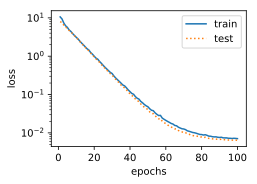

In [8]:
#正常拟合
fitAndPlot(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])

final epoch: train loss 131.10655 test loss 85.82355
weight: [[20.758667]] 
bias: [-0.44893473]


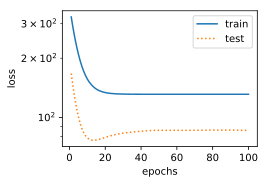

In [13]:
#线性函数在非线性函数上的欠拟合
fitAndPlot(features[:n_train, :], features[n_train:, :], labels[:n_train],
labels[n_train:])


final epoch: train loss 22.110016 test loss 184.17361
weight: [[7.3083277]] 
bias: [-4.5002594]


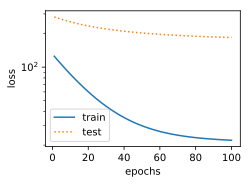

In [14]:
#训练样本不足导致过拟合
fitAndPlot(features[:2, :], features[2:, :], labels[:2],
labels[2:])


In [1]:
#高维线性检验正则化对过拟合的优化
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05
features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [2]:
#初始化参数
def init_params():
    w = nd.random.normal(scale=1,shape=(num_inputs,1))
    b = nd.zeros(shape = (1,))
    w.attach_grad()
    b.attach_grad()
    return [w,b]


In [3]:
#定义L2范数惩罚项
def l2_penalty(w):
    return(w**2).sum()/2

In [9]:
batch_size, num_epochs, lr = 1, 100, 0.003
net,loss = d2l.linreg,d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),batch_size,shuffle=True)

def fit_and_plot(lambd):
    w,b = init_params()
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                #添加L2
                l = loss(net(X,w,b,),y)+lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features,w,b),train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features,w,b),test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())


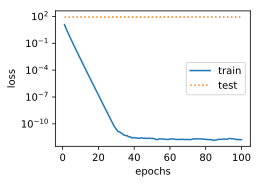

L2 norm of w: 13.530377


In [10]:
#不启用L2
fit_and_plot(lambd=0)

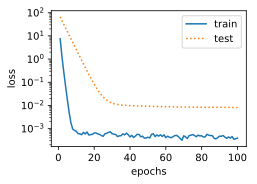

L2 norm of w: 0.04325313


In [11]:
#启用L2
fit_and_plot(lambd=3)

In [12]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数衰减。权重名称⼀般是以weight结尾
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',{'learning_rate': lr, 'wd': wd})
    # 不对偏差参数衰减。偏差名称⼀般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
{'learning_rate': lr})
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # 对两个Trainer实例分别调⽤step函数，从⽽分别更新权重和偏差
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

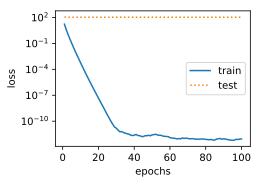

L2 norm of w: 14.478209


In [13]:
fit_and_plot_gluon(0)

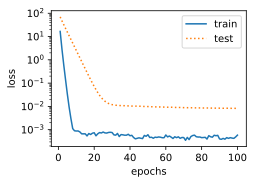

L2 norm of w: 0.04184704


In [14]:
fit_and_plot_gluon(3)

In [3]:
#丢弃法
import d2lzh as d2l
from mxnet import autograd,gluon,init,nd
from mxnet.gluon import loss as gloss,nn

#定义丢弃
def dropout(X,drop_prob):
    assert 0 <= drop_prob <=1   #验证概率合法
    keep_prob = 1-drop_prob
    
    if keep_prob == 0:
        return X.zeros_like()
    mask = nd.random.uniform(0,1,X.shape)<keep_prob
    return mask * X/keep_prob

    

In [5]:
X = nd.arange(16).reshape((2,8))
dropout(X,0)


[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
<NDArray 2x8 @cpu(0)>

In [6]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = nd.random.normal(scale=0.01,shape=(num_inputs,num_hiddens1))
b1 = nd.zeros(num_hiddens1)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens1, num_hiddens2))
b2 = nd.zeros(num_hiddens2)
W3 = nd.random.normal(scale=0.01, shape=(num_hiddens2, num_outputs))
b3 = nd.zeros(num_outputs)

params = [W1,b1,W2,b2,W3,b3]
for param in params:
    param.attach_grad()

In [8]:
'''下⾯定义的模型将全连接层和激活函数ReLU串起来，并对每个激活函数的输出使⽤丢弃法。我
们可以分别设置各个层的丢弃概率。'''
drop_prob1,drop_prob2 = 0.2,0.5

def net(X):
    X = X.reshape((-1,num_inputs))
    H1 = (nd.dot(X,W1)+b1).relu()
    if autograd.is_training():        #训练模式丢弃
        H1 = dropout(H1,drop_prob1)
    H2 = (nd.dot(H1,W2)+b2).relu()
    if autograd.is_training():
        H2 = dropout(H2,drop_prob2)
    return nd.dot(H2,W3)+b3

In [9]:
num_epochs, lr, batch_size = 5, 0.5, 256
loss = gloss.SoftmaxCrossEntropyLoss()
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,params, lr)


epoch 1, loss 1.1214, train acc 0.561, test acc 0.760
epoch 2, loss 0.5874, train acc 0.782, test acc 0.828
epoch 3, loss 0.4914, train acc 0.819, test acc 0.854
epoch 4, loss 0.4522, train acc 0.835, test acc 0.864
epoch 5, loss 0.4196, train acc 0.846, test acc 0.862


In [10]:
net = nn.Sequential()
net.add(nn.Dense(256,activation = 'relu'),nn.Dropout(drop_prob1),
        nn.Dense(256,activation = 'relu'),nn.Dropout(drop_prob2),
       nn.Dense(10))
net.initialize(init.Normal(sigma = 0.01))

In [13]:
trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate' : lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None,
None, trainer)

epoch 1, loss 1.1241, train acc 0.563, test acc 0.771
epoch 2, loss 0.5753, train acc 0.788, test acc 0.833
epoch 3, loss 0.4851, train acc 0.823, test acc 0.843
epoch 4, loss 0.4447, train acc 0.839, test acc 0.862
epoch 5, loss 0.4137, train acc 0.852, test acc 0.864
